In [23]:
#!/usr/bin/env python
# coding: utf-8


'''Import all modules'''
import sys
import dns.message
import dns.query
import time
import pandas as pd
import numpy as np
import datetime


'''Configuration parameters'''
root_servers = [
    '198.41.0.4',
    '199.9.14.201',
    '192.33.4.12',
    '199.7.91.13',
    '192.203.230.10',
    '192.5.5.241',
    '192.112.36.4',
    '198.97.190.53',
    '192.36.148.17',
    '192.58.128.30',
    '193.0.14.129',
    '199.7.83.42',
    '202.12.27.33'
]

timeout = 1

local_dns_server = [
    '8.8.8.8'
]
rdata_type_map = {
    'A': dns.rdatatype.A,
    'NS': dns.rdatatype.NS,
    'MX': dns.rdatatype.MX,
    'CNAME': dns.rdatatype.CNAME
}


class MetaData:
    def __init__(self,time,size):
        self.time = time
        self.size = size


'''Function to fetch records from root DNS servers'''
def resolve_from_root(hostname,rdtype):
    query = dns.message.make_query(hostname, rdtype)
    for server in root_servers:
        server_response = resolve_from_server(hostname,rdtype,server)
        if server_response:
            return server_response
        else:
            continue



'''Function to fetch records from NS'''
def resolve_from_server(hostname,rdtype,server):
    #print(hostname,rdtype,server)
    query = dns.message.make_query(dns.name.from_text(str(hostname)), rdtype)
    try:
        response = dns.query.udp(query, server, timeout=5)
        return response
    except Exception as e:
        raise e


''' Recursive function to get records'''
def resolve_iteratively(hostname,rdtype,response: [dns.message.Message]):
    if len(response.answer)>0:
        records = []
        for r in response.answer:
            noRecords = True
            for rr in r:
                if(rr.rdtype==rdata_type_map[rdtype]):
                    noARecord = False
                    records.append(rr.to_text())
            if(noRecords):
                for rr in r:
                    cnames = []
                    cname_records = []
                    if(rr.rdtype==rdata_type_map['CNAME']):
                        cnames.append(rr.to_text())
                for cname in cnames:
                    records_from_cname = main_helper(cname,rdtype)
                    if(len(records_from_cname)>0):
                        records = records_from_cname
            return records
    elif len(response.additional)>0:
        ips = []
        for r in response.additional:
            for rr in r:
                if(rr.rdtype==dns.rdatatype.A):
                    ips.append(rr.address)
        for ip in ips:
            response_subdomain = resolve_from_server(hostname,rdtype,ip)
            if response_subdomain is not None:
                return resolve_iteratively(hostname,rdtype,response_subdomain)
            else:
                continue
    elif len(response.authority)>0:
        nss = []
        for r in response.authority:
            for rr in r:
                nss.append(rr.target)
        for ns in nss:
            ips = main_helper(ns,rdtype)
            if(len(ips)>0):
                final_ips = []
                for ip in ips:
                    response2 = resolve_from_server(hostname,rdtype,ip)
                    final_ips = resolve_iteratively(hostname,rdtype,response2)
                    if final_ips is not None:
                        return final_ips
                    else:
                        continue
    else:
        raise Exception 



def print_like_dig(hostname,rdtype,records,metadata):
    print(';;QUESTION SECTION:')
    print(hostname + "     " + "IN    " + rdtype)
    print("\n")
    print(';;ANSWER SECTION:')
    for record in records:
        print(hostname + "     " + "IN    " + rdtype + "    " + record)
    print("\n")
    print('Query time: ' + str(int(metadata.time * 1000)) + ' msec')
    print('WHEN:', datetime.datetime.now().strftime("%a %b %d %H:%M:%S %Y"))
    print('MSG SIZE rcvd: ', metadata.size, '\n')




def main_helper(hostname,rdtype):
    rr = None
    for server in root_servers:
        response = resolve_from_server(hostname,rdtype,server)
        if response is not None:
            rr = resolve_iteratively(hostname,rdtype,response)
            break
    return rr



def main(hostname,rdtype):
    now = datetime.datetime.now()
    start = time.time()
    records = main_helper(hostname,rdtype)
    total_time = time.time() - start
    size = sys.getsizeof(records)
    print_like_dig(hostname,rdtype,records,MetaData(total_time,size))
    return total_time



# if __name__ == '__main__':
#     domain = sys.argv[1]
#     if sys.argv[2] is not None:
#         rdtype = sys.argv[2]
#     else:
#         rdtype = 'A'
#     rdtype = rdtype.upper()
#     domain = domain.replace("https://www.", "");
#     domain = domain.replace("http://www.", "");
#     domain = domain.replace("www.", "");
#     print(domain)
#     main(domain,rdtype)

In [88]:
top_websites = [
    'google.com',
    'facebook.com',
    'youtube.com',
    'tmall.com',
    'baidu.com',
    'qq.com',
    '360.cn'
    'sohu.com',
    'taobao.com',
    'jd.com',
    'amazon.com',
    'yahoo.com',
    'wikipedia.org',
    'weibo.com',
    'sina.com.cn',
    'zoom.us',
    'xinhuanet.com',
    'live.com',
    'netflix.com',
    'reddit.com',
    'instagram.com',
    'microsoft.com',
    'office.com',
    'google.com.hk',
    'panda.tv'
]

In [89]:
time_dataframe = pd.DataFrame(index=[ website for website in top_websites], columns=np.arange(10))

In [173]:
comparison_dataframe = pd.DataFrame(index=['Mydig','LocalDNS','GoogleDNS'],columns=np.arange(25))

In [184]:
for website in top_websites:
    time_elapsed = main(website,'A')
    time_dataframe[8][website] = time_elapsed

;;QUESTION SECTION:
google.com     IN    A


;;ANSWER SECTION:
google.com     IN    A    142.250.65.238


Query time: 344 msec
WHEN: Tue Sep 21 15:29:27 2021
MSG SIZE rcvd:  88 

;;QUESTION SECTION:
facebook.com     IN    A


;;ANSWER SECTION:
facebook.com     IN    A    157.240.241.35


Query time: 40 msec
WHEN: Tue Sep 21 15:29:27 2021
MSG SIZE rcvd:  88 

;;QUESTION SECTION:
youtube.com     IN    A


;;ANSWER SECTION:
youtube.com     IN    A    142.250.176.206


Query time: 94 msec
WHEN: Tue Sep 21 15:29:27 2021
MSG SIZE rcvd:  88 



<ipython-input-184-2f6004fc853a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_dataframe[8][website] = time_elapsed


;;QUESTION SECTION:
tmall.com     IN    A


;;ANSWER SECTION:
tmall.com     IN    A    140.205.94.193
tmall.com     IN    A    140.205.130.99


Query time: 258 msec
WHEN: Tue Sep 21 15:29:27 2021
MSG SIZE rcvd:  88 

;;QUESTION SECTION:
baidu.com     IN    A


;;ANSWER SECTION:
baidu.com     IN    A    220.181.38.251
baidu.com     IN    A    220.181.38.148


Query time: 289 msec
WHEN: Tue Sep 21 15:29:27 2021
MSG SIZE rcvd:  88 

;;QUESTION SECTION:
qq.com     IN    A


;;ANSWER SECTION:
qq.com     IN    A    183.3.226.35
qq.com     IN    A    203.205.254.157
qq.com     IN    A    123.151.137.18
qq.com     IN    A    61.129.7.47


Query time: 501 msec
WHEN: Tue Sep 21 15:29:28 2021
MSG SIZE rcvd:  88 

;;QUESTION SECTION:
360.cnsohu.com     IN    A


;;ANSWER SECTION:
360.cnsohu.com     IN    A    3.223.115.185


Query time: 558 msec
WHEN: Tue Sep 21 15:29:28 2021
MSG SIZE rcvd:  88 

;;QUESTION SECTION:
taobao.com     IN    A


;;ANSWER SECTION:
taobao.com     IN    A    140.205.220.9

In [185]:
time_dataframe['mean'] = time_dataframe.mean(axis=1)

In [176]:
time_dataframe['mean'] = time_dataframe['mean']*1000

In [177]:
time_dataframe

,0,1,2,3,4,5,6,7,8,9,mean
google.com,0.2278,0.051833,0.052178,0.060195,0.054009,0.054524,0.060017,0.054103,0.054156,0.053189,6629.304496
facebook.com,0.043656,0.042553,0.041795,0.039373,0.039664,0.039227,0.041463,0.042475,0.044473,0.042197,3827.689106
youtube.com,0.303872,0.057535,0.061269,0.058461,0.054035,0.058459,0.056398,0.056659,0.059785,0.054869,7541.412830
tmall.com,0.246153,0.109775,0.112989,0.107592,0.108279,0.111875,0.109491,0.114164,0.108242,0.111524,11386.231769
baidu.com,0.256405,0.25586,0.268952,0.353049,0.294265,0.25905,0.274608,0.318356,0.342563,0.274681,26606.973930
qq.com,0.381473,0.29371,0.323619,0.305471,0.316907,0.333304,0.31677,0.322738,0.30598,0.305946,29436.156858
360.cnsohu.com,0.169861,0.173222,0.171469,0.170516,0.174438,0.174832,0.174693,0.172859,0.178591,0.166469,15856.533701
taobao.com,0.112768,0.113856,0.110817,0.108348,0.114898,0.111338,0.109097,0.112324,0.109225,0.108132,10199.192351
jd.com,0.359373,0.397594,0.337874,0.43741,0.457186,0.341964,0.432613,0.413273,0.427393,0.354263,36350.293810
amazon.com,0.095449,0.093933,0.08298,0.090435,0.080889,0.077893,0.088981,0.083297,0.090552,0.084269,7976.042119


In [188]:
for i in range(24):
    comparison_dataframe.iloc[0,i] = time_dataframe['mean'][i]

In [189]:
import dns.resolver

'''Generic function to get average time of DNS response'''
def fetch_from_resolver(website, resolver):
    resolver = dns.resolver.Resolver(configure=False)
    resolver.nameservers = [resolver]
    
    start = time.time()
    
    for i in range(0, 10):
        answer = dns.resolver.resolve(website, 'A')
    
    end = time.time() - start
    end = end/10
    return end*1000

In [190]:
i = 0
for wesbite in top_websites:
    comparison_dataframe.iloc[1,i] = fetch_from_resolver(website,'130.245.255.4')
    i += 1
i = 0
for wesbite in top_websites:
    comparison_dataframe.iloc[2,i] = fetch_from_resolver(website,'8.8.8.8')
    i += 1

In [191]:
comparison_dataframe

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Mydig,602.756054,348.009279,685.660776,1035.238366,2419.074464,2676.323456,1441.694565,927.316625,3304.925449,725.197535,...,7706.144581,668.939447,866.113532,844.522704,728.412483,635.445372,750.656229,3348.442721,6059.184851,NaN
LocalDNS,106.986523,7.373476,7.105708,7.6828,7.669806,8.260679,32.880807,31.4358,7.243514,7.925916,...,8.369613,7.501101,6.888103,7.820678,6.929517,6.832623,6.72791,6.983995,7.087493,NaN
GoogleDNS,8.643723,7.07562,6.980705,7.548308,8.036971,7.542014,8.274198,7.124925,6.841207,7.151175,...,8.325934,6.97248,7.292175,6.659102,6.65679,6.70321,6.722999,6.663013,7.1666,NaN


In [192]:
comparison_dataframe = comparison_dataframe.iloc[: , :-1]

In [193]:
comparison_dataframe

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Mydig,602.756054,348.009279,685.660776,1035.238366,2419.074464,2676.323456,1441.694565,927.316625,3304.925449,725.197535,...,1470.262677,7706.144581,668.939447,866.113532,844.522704,728.412483,635.445372,750.656229,3348.442721,6059.184851
LocalDNS,106.986523,7.373476,7.105708,7.6828,7.669806,8.260679,32.880807,31.4358,7.243514,7.925916,...,15.113926,8.369613,7.501101,6.888103,7.820678,6.929517,6.832623,6.72791,6.983995,7.087493
GoogleDNS,8.643723,7.07562,6.980705,7.548308,8.036971,7.542014,8.274198,7.124925,6.841207,7.151175,...,6.955791,8.325934,6.97248,7.292175,6.659102,6.65679,6.70321,6.722999,6.663013,7.1666


In [194]:
df2 = comparison_dataframe.T

In [195]:
df2 = df2.cumsum()

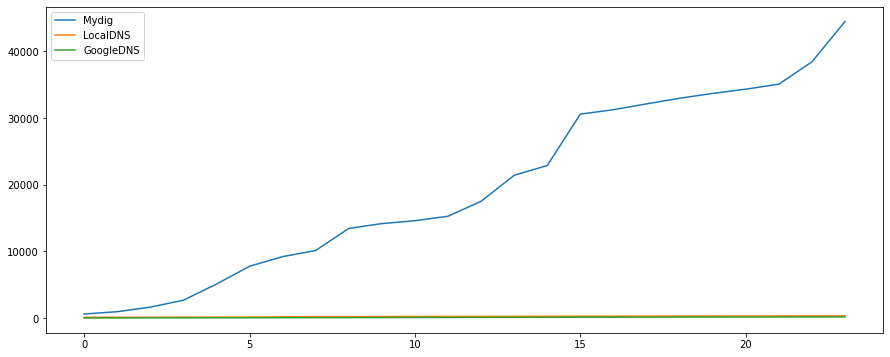

In [196]:
lines = df2.plot.line(figsize=(15,6))

From the above graph we can observe that both GoogleDNS and LocalDNS perform almost identical, whereas Mydig is comparitively slower. 